In [ ]:
# Gỡ cài đặt các phiên bản có thể gây xung đột để làm sạch môi trường
!pip uninstall -y evaluate datasets transformers torch torchvision

# Cài đặt lại các thư viện theo đúng thứ tự
!pip install torch torchvision
!pip install -q evaluate transformers

# py -3.10 -m pip install torch torchvision
# py -3.10 -m pip install -q evaluate transformers

Found existing installation: evaluate 0.4.5
Uninstalling evaluate-0.4.5:
  Successfully uninstalled evaluate-0.4.5
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: torch 2.7.1
Uninstalling torch-2.7.1:
  Successfully uninstalled torch-2.7.1
Found existing installation: torchvision 0.22.1
Uninstalling torchvision-0.22.1:
  Successfully uninstalled torchvision-0.22.1
  Using cached torch-2.7.1-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.22.1-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
Using cached torch-2.7.1-cp311-cp311-win_amd64.whl (216.1 MB)
Using cached torchvision-0.22.1-cp311-cp311-win_amd64.whl (1.7 MB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\GiaHyTran\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\GiaHyTran\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [3]:
!pip install git+https://github.com/hendrycks/math.git#subdirectory=math_equivalence    

^C


  Cloning https://github.com/hendrycks/math.git to c:\users\giahytran\appdata\local\temp\pip-req-build-dpbcb2ix


  Running command git clone --filter=blob:none --quiet https://github.com/hendrycks/math.git 'C:\Users\GiaHyTran\AppData\Local\Temp\pip-req-build-dpbcb2ix'
  error: RPC failed; curl 56 Recv failure: Connection was reset
  error: 2433 bytes of body are still expected
  fetch-pack: unexpected disconnect while reading sideband packet
  fatal: early EOF
  fatal: index-pack failed
  fatal: could not fetch 2884bd5e0ebe3af32f148e407ca9648153b6f2fa from promisor remote
  You can inspect what was checked out with 'git status'
  and retry with 'git restore --source=HEAD :/'

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/hendrycks/math.git 'C:\Users\GiaHyTran\AppData\Local\Temp\pip-req-build-dpbcb2ix' did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https:

In [1]:
import json
import time
import pandas as pd
from openai import OpenAI
from tqdm import tqdm
from evaluate import load

# Import TẤT CẢ các mẫu prompt từ file prompt.py
from prompt import *

c:\Users\GiaHyTran\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# !!! QUAN TRỌNG: Hãy điền API Key của bạn vào đây
api_key = "..."  # Thay thế bằng API Key của bạn

# 1. Khởi tạo Client với API Key
client = OpenAI(api_key=api_key)

# 2. Định nghĩa các model và các kịch bản prompt
MODELS_TO_COMPARE = ["gpt-3.5-turbo", "gpt-4o-mini"]
PROMPTS_TO_TEST = {
    "English Prompt (Zero-shot)": ENGLISH_ZERO,
    "English Prompt (Few-shot)": ENGLISH_ONE,
    "English Prompt (CoT)": ENGLISH_THREE,
    "Persian Prompt (Zero-shot)": PERSIAN_ZERO,
    "Persian Prompt (Few-shot)": PERSIAN_ONE,
    "Persian Prompt (CoT)": PERSIAN_THREE,
}

# 3. Tải toàn bộ dữ liệu từ file math.jsonl
try:
    full_data = []
    with open('math.jsonl', 'r', encoding='utf-8') as reader:
        for line in reader:
            full_data.append(json.loads(line))
    
    # Tự động tính toán và lấy một nửa số lượng mẫu
    SAMPLE_SIZE = 178
    
    # Lấy một phần dữ liệu để chạy thử
    all_data = full_data[:SAMPLE_SIZE] 
    
    print(f"✅ Đã tải thành công {len(full_data)} bài toán.")
    print(f" dụng một nửa số lượng mẫu: {len(all_data)} bài toán.")

except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file 'math.jsonl'.")

✅ Đã tải thành công 178 bài toán.
 dụng một nửa số lượng mẫu: 178 bài toán.


In [3]:
def get_answer_from_model(prompt, model_name):
    """
    Hàm này nhận một prompt và tên model, sau đó trả về câu trả lời.
    """
    try:
        response = client.chat.completions.create(
          model=model_name,
          messages=[
                {"role": "system", "content": "You are a math expert. Provide a step-by-step solution and enclose the final answer in [پاسخ] tags."},
                {"role": "user", "content": prompt}
            ],
          temperature=0,
          max_tokens=512 # Tăng token để chứa cả phần giải thích
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"\nLỗi khi gọi model {model_name}: {e}")
        return "ERROR"

def preserve_digit(input_string):
    """
    Hàm này từ code gốc, dùng để trích xuất phần số từ câu trả lời.
    """
    end_idx = len(input_string) - 1
    while end_idx >= 0 and not input_string[end_idx].isdigit():
        end_idx -= 1
    start_idx = end_idx

    while start_idx >= 0 and (input_string[start_idx].isdigit() or input_string[start_idx] in ['.', ',', '/', '\\', '{', '}']):
        start_idx -= 1
        
    return input_string[start_idx+1:end_idx+1]

def extract_answer(response_text):
    """
    Hàm này tìm thẻ [پاسخ], sau đó dùng preserve_digit để lấy câu trả lời cuối cùng.
    """
    try:
        answer_idx = response_text.rfind("[پاسخ]")
        if answer_idx != -1:
            result_part = response_text[answer_idx:]
            return preserve_digit(result_part)
        else:
            return preserve_digit(response_text)
    except:
        return ""

In [4]:
# Dictionary để lưu kết quả cuối cùng
final_results = {}

# Bắt đầu vòng lặp lớn
for model_name in MODELS_TO_COMPARE:
    print(f"============== BẮT ĐẦU MODEL: {model_name} ==============")
    final_results[model_name] = {}
    
    # Vòng lặp bên trong: chạy qua từng loại prompt
    for prompt_name, prompt_template in PROMPTS_TO_TEST.items():
        print(f"--- Đang chạy kịch bản: {prompt_name} ---")
        
        model_predictions_raw = []
        
        # Chạy qua toàn bộ dữ liệu mẫu
        for sample in tqdm(all_data, desc=f"Querying {prompt_name}"):
            prompt = prompt_template.format(problem=sample['problem'])
            answer = get_answer_from_model(prompt, model_name)
            model_predictions_raw.append(answer)
            time.sleep(1)

        # Lưu lại danh sách các câu trả lời thô của model
        final_results[model_name][prompt_name] = model_predictions_raw
        print(f"--- Hoàn thành thu thập dữ liệu cho kịch bản: {prompt_name} ---\n")

print("✨ Đã hoàn thành tất cả các thử nghiệm.")

============== BẮT ĐẦU MODEL: gpt-3.5-turbo ==============
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 178/178 [13:10<00:00,  4.44s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (Few-shot) ---


Querying English Prompt (Few-shot): 100%|██████████| 178/178 [12:14<00:00,  4.13s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Few-shot) ---

--- Đang chạy kịch bản: English Prompt (CoT) ---


Querying English Prompt (CoT): 100%|██████████| 178/178 [10:41<00:00,  3.61s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (CoT) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 178/178 [14:11<00:00,  4.78s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Few-shot) ---


Querying Persian Prompt (Few-shot): 100%|██████████| 178/178 [12:26<00:00,  4.19s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Few-shot) ---

--- Đang chạy kịch bản: Persian Prompt (CoT) ---


Querying Persian Prompt (CoT): 100%|██████████| 178/178 [11:26<00:00,  3.86s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (CoT) ---

============== BẮT ĐẦU MODEL: gpt-4o-mini ==============
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 178/178 [25:11<00:00,  8.49s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (Few-shot) ---


Querying English Prompt (Few-shot): 100%|██████████| 178/178 [20:42<00:00,  6.98s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Few-shot) ---

--- Đang chạy kịch bản: English Prompt (CoT) ---


Querying English Prompt (CoT): 100%|██████████| 178/178 [19:41<00:00,  6.64s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (CoT) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 178/178 [23:07<00:00,  7.80s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Few-shot) ---


Querying Persian Prompt (Few-shot): 100%|██████████| 178/178 [17:25<00:00,  5.87s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Few-shot) ---

--- Đang chạy kịch bản: Persian Prompt (CoT) ---


Querying Persian Prompt (CoT): 100%|██████████| 178/178 [18:45<00:00,  6.32s/it]

--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (CoT) ---

✨ Đã hoàn thành tất cả các thử nghiệm.


In [5]:
print("\n\n=============== BẢNG SO SÁNH HIỆU NĂNG GIẢI TOÁN ===============")

# Tải evaluator từ thư viện evaluate
evaluator = load("competition_math")

# DataFrame để lưu trữ chỉ số Accuracy
accuracy_results = {}

# Lấy danh sách đáp án đúng
true_answers = [sample['target'] for sample in all_data]

# Vòng lặp qua kết quả của từng model để tính toán
for model_name, prompt_results in final_results.items():
    accuracy_results[model_name] = {}
    for prompt_name, raw_predictions in prompt_results.items():
        # Trích xuất câu trả lời cuối cùng từ mỗi dự đoán thô
        cleaned_predictions = [extract_answer(pred) for pred in raw_predictions]
        
        # Dùng evaluator để tính toán
        results = evaluator.compute(references=true_answers, predictions=cleaned_predictions)
        
        # Lưu kết quả accuracy (dưới dạng %)
        accuracy = results['accuracy'] * 100
        accuracy_results[model_name][prompt_name] = accuracy

# Tạo và in bảng so sánh cuối cùng
summary_df = pd.DataFrame(accuracy_results)
summary_df = summary_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, float) else x)
summary_df.columns.name = "Model"
summary_df.index.name = "Prompt / Kịch bản"

print("\n\n=============== BẢNG TÓM TẮT ACCURACY (Đối sánh chính xác) ===============")
print(summary_df.to_markdown())



=============== BẢNG SO SÁNH HIỆU NĂNG GIẢI TOÁN ===============


=============== BẢNG TÓM TẮT ACCURACY (Đối sánh chính xác) ===============
| Prompt / Kịch bản          | gpt-3.5-turbo   | gpt-4o-mini   |
|:---------------------------|:----------------|:--------------|
| English Prompt (Zero-shot) | 37.64%          | 42.13%        |
| English Prompt (Few-shot)  | 39.89%          | 60.67%        |
| English Prompt (CoT)       | 35.96%          | 61.24%        |
| Persian Prompt (Zero-shot) | 34.27%          | 52.25%        |
| Persian Prompt (Few-shot)  | 37.08%          | 56.74%        |
| Persian Prompt (CoT)       | 36.52%          | 59.55%        |


C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_22252\1237559391.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df = summary_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, float) else x)




📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH (GIẢI TOÁN) ===============📈


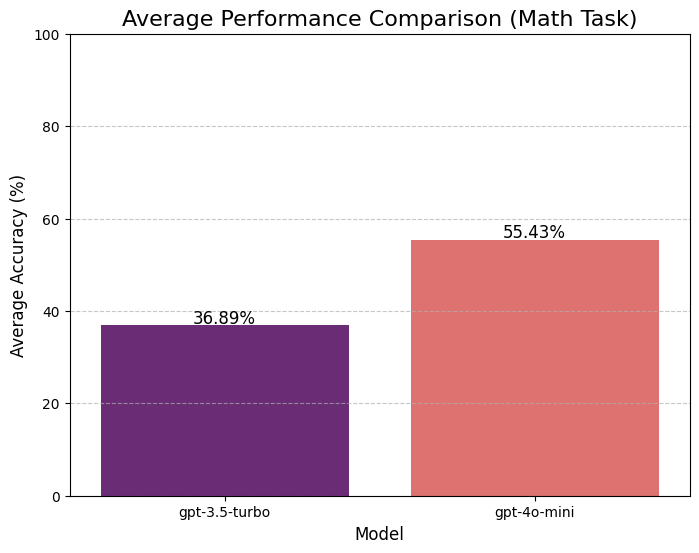

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

math_data = {
    'Experiment': [
        'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)',
        'English Prompt (Few-shot)', 'Persian Prompt (Few-shot)',
        'English Prompt (CoT)', 'Persian Prompt (CoT)'
    ] * 2,
    'Model': [
        'gpt-3.5-turbo'] * 6 + ['gpt-4o-mini'] * 6
    ,
    'Accuracy': [
        # gpt-3.5-turbo scores
        37.64, 34.27, 39.89, 37.08, 35.96, 36.52,
        # gpt-4o-mini scores
        42.13, 52.25, 60.67, 56.74, 61.24, 59.55
    ]
}

df_math = pd.DataFrame(math_data)

print("\n\n📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH (GIẢI TOÁN) ===============📈")

# Nhóm theo model và tính điểm accuracy trung bình
df_summary = df_math.groupby('Model')['Accuracy'].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=df_summary, hue='Model', palette='magma', legend=False)

# Tùy chỉnh biểu đồ
plt.title('Average Performance Comparison (Math Task)', fontsize=16)
plt.ylabel('Average Accuracy (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên mỗi cột
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()

In [7]:
# Hiển thị bảng tóm tắt chi tiết
print("\n\n📊=============== BẢNG TÓM TẮT HIỆU SUẤT CHI TIẾT (GIẢI TOÁN) ===============📊")
# Sắp xếp lại DataFrame theo thứ tự mong muốn
prompt_order = [
    'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)',
    'English Prompt (Few-shot)', 'Persian Prompt (Few-shot)', # Few-shot is like 1-shot
    'English Prompt (CoT)', 'Persian Prompt (CoT)' # CoT is like 3-shot
]
df_math['Experiment'] = pd.Categorical(df_math['Experiment'], categories=prompt_order, ordered=True)
df_math = df_math.sort_values('Experiment')

# Tạo bảng pivot
pivot_detailed = df_math.pivot_table(index='Experiment', columns='Model', values='Accuracy')
print(pivot_detailed.to_markdown(floatfmt=".2f"))



📊=============== BẢNG TÓM TẮT HIỆU SUẤT CHI TIẾT (GIẢI TOÁN) ===============📊
| Experiment                 |   gpt-3.5-turbo |   gpt-4o-mini |
|:---------------------------|----------------:|--------------:|
| English Prompt (Zero-shot) |           37.64 |         42.13 |
| Persian Prompt (Zero-shot) |           34.27 |         52.25 |
| English Prompt (Few-shot)  |           39.89 |         60.67 |
| Persian Prompt (Few-shot)  |           37.08 |         56.74 |
| English Prompt (CoT)       |           35.96 |         61.24 |
| Persian Prompt (CoT)       |           36.52 |         59.55 |


C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_22252\210507618.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_detailed = df_math.pivot_table(index='Experiment', columns='Model', values='Accuracy')
